<div align="center">
<h1><img width="30" src="https://madewithml.com/static/images/rounded_logo.png">&nbsp;<a href="https://madewithml.com/">Made With ML</a></h1>
Applied ML · MLOps · Production
<br>
Join 30K+ developers in learning how to responsibly <a href="https://madewithml.com/about/">deliver value</a> with ML.
    <br>
</div>

<br>

<div align="center">
    <a target="_blank" href="https://madewithml.com"><img src="https://img.shields.io/badge/Subscribe-30K-brightgreen"></a>&nbsp;
    <a target="_blank" href="https://github.com/GokuMohandas/Made-With-ML"><img src="https://img.shields.io/github/stars/GokuMohandas/Made-With-ML.svg?style=social&label=Star"></a>&nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/goku"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
    <a target="_blank" href="https://twitter.com/GokuMohandas"><img src="https://img.shields.io/twitter/follow/GokuMohandas.svg?label=Follow&style=social"></a>
    <br>
    🔥&nbsp; Among the <a href="https://github.com/topics/deep-learning" target="_blank">top ML</a> repositories on GitHub
</div>

<br>
<hr>

# Embeddings

In this lesson, we will motivate the need for embeddings, which are capable of capturing the contextual, semantic and syntactic meaning in data.

<div align="left">
<a target="_blank" href="https://madewithml.com/courses/foundations/embeddings/"><img src="https://img.shields.io/badge/📖 Read-blog post-9cf"></a>&nbsp;
<a href="https://github.com/GokuMohandas/Made-With-ML/blob/main/notebooks/12_Embeddings.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/GokuMohandas/Made-With-ML/blob/main/notebooks/12_Embeddings.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# Overview


While one-hot encoding allows us to preserve the structural information, it does poses two major disadvantages. 

- linearly dependent on the number of unique tokens in our vocabulary, which is a problem if we're dealing with a large corpus.
- representation for each token does not preserve any relationship with respect to other tokens.

In this notebook, we're going to motivate the need for embeddings and how they address all the shortcomings of one-hot encoding. The main idea of embeddings is to have fixed length representations for the tokens in a text regardless of the number of tokens in the vocabulary. With one-hot encoding, each token is represented by an array of size [1 X `vocab_size`], but with embeddings, each token now has the shape [1 X `embed_dim`]. The values in the representation will are not fixed binary values but rather, changing floating points allowing for fine-grained learned representations.

* **Objective:**  Represent tokens in text that capture the intrinsic semantic relationships.
* **Advantages:** 
    * Low-dimensionality while capturing relationships.
    * Interpretable token representations
* **Disadvantages:** Can be computationally intensive to precompute.
* **Miscellaneous:** There are lot's of pretrained embeddings to choose from but you can also train your own from scratch.




# Learning Embeddings

We can learn embeddings by creating our models in PyTorch but first, we're going to use a library that specializes in embeddings and topic modeling called [Gensim](https://radimrehurek.com/gensim/). 

In [ ]:
import nltk
nltk.download('punkt');
import numpy as np
import re
import urllib

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
SEED = 1234

In [ ]:
# Set seed for reproducibility
np.random.seed(SEED)

In [ ]:
# Split text into sentences
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
book = urllib.request.urlopen(url="https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/harrypotter.txt")
sentences = tokenizer.tokenize(str(book.read()))
print (f"{len(sentences)} sentences")

12443 sentences


In [ ]:
def preprocess(text):
    """Conditional preprocessing on our text."""
    # Lower
    text = text.lower()

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric chars
    text = re.sub(' +', ' ', text)  # remove multiple spaces
    text = text.strip()

    # Separate into word tokens
    text = text.split(" ")

    return text

In [ ]:
# Preprocess sentences
print (sentences[11])
sentences = [preprocess(sentence) for sentence in sentences]
print (sentences[11])

Snape nodded, but did not elaborate.
['snape', 'nodded', 'but', 'did', 'not', 'elaborate']


But how do we learn the embeddings the first place? The intuition behind embeddings is that the definition of a token depends on the token itself but on its context. There are several different ways of doing this:

1. Given the word in the context, predict the target word (CBOW - continuous bag of words).
2. Given the target word, predict the context word (skip-gram).
3. Given a sequence of words, predict the next word (LM - language modeling).

All of these approaches involve create data to train our model on. Every word in a sentence becomes the target word and the context words are determines by a window. In the image below (skip-gram), the window size is 2 (2 words to the left and right of the target word). We repeat this for every sentence in our corpus and this results in our training data for the unsupervised task. This in an unsupervised learning technique since we don't have official labels for contexts. The idea is that similar target words will appear with similar contexts and we can learn this relationship by repeatedly training our mode with (context, target) pairs.

<div align="left">
<img src="https://madewithml.com/static/images/foundations/python/skipgram.png" width="600">
</div>

We can learn embeddings using any of these approaches above and some work better than others. You can inspect the learned embeddings but the best way to choose an approach is to empirically validate the performance on a supervised task.

## Word2Vec

When we have large vocabularies to learn embeddings for, things can get complex very quickly. Recall that the backpropagation with softmax updates both the correct and incorrect class weights. This becomes a massive computation for every backwas pass we do so a workaround is to use [negative sampling](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/) which only updates the correct class and a few arbitrary incorrect classes (`NEGATIVE_SAMPLING`=20). We're able to do this because of the large amount of training data where we'll see the same word as the target class multiple times.



In [ ]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [ ]:
EMBEDDING_DIM = 100
WINDOW = 5
MIN_COUNT = 3 # Ignores all words with total frequency lower than this
SKIP_GRAM = 1 # 0 = CBOW
NEGATIVE_SAMPLING = 20

In [ ]:
# Super fast because of optimized C code under the hood
w2v = Word2Vec(
    sentences=sentences, size=EMBEDDING_DIM, 
    window=WINDOW, min_count=MIN_COUNT, 
    sg=SKIP_GRAM, negative=NEGATIVE_SAMPLING)
print (w2v)

Word2Vec(vocab=4937, size=100, alpha=0.025)


In [ ]:
# Vector for each word
w2v.wv.get_vector("potter")

array([-0.11787166, -0.2702948 ,  0.24332453,  0.07497228, -0.5299148 ,
        0.17751476, -0.30183575,  0.17060578, -0.0342238 , -0.331856  ,
       -0.06467848,  0.02454215,  0.4524056 , -0.18918884, -0.22446074,
        0.04246538,  0.5784022 ,  0.12316586,  0.03419832,  0.12895502,
       -0.36260423,  0.06671549, -0.28563526, -0.06784113, -0.0838319 ,
        0.16225453,  0.24313857,  0.04139925,  0.06982274,  0.59947336,
        0.14201492, -0.00841052, -0.14700615, -0.51149386, -0.20590985,
        0.00435914,  0.04931103,  0.3382509 , -0.06798466,  0.23954925,
       -0.07505646, -0.50945646, -0.44729665,  0.16253233,  0.11114362,
        0.05604156,  0.26727834,  0.43738437, -0.2606872 ,  0.16259147,
       -0.28841105, -0.02349186,  0.00743417,  0.08558545, -0.0844396 ,
       -0.44747537, -0.30635086, -0.04186366,  0.11142804,  0.03187608,
        0.38674814, -0.2663519 ,  0.35415238,  0.094676  , -0.13586426,
       -0.35296437, -0.31428036, -0.02917303,  0.02518964, -0.59

In [ ]:
# Get nearest neighbors (excluding itself)
w2v.wv.most_similar(positive="scar", topn=5)

[('pain', 0.9274871349334717),
 ('forehead', 0.9020695686340332),
 ('heart', 0.8953317999839783),
 ('mouth', 0.8939940929412842),
 ('throat', 0.8922691345214844)]

In [ ]:
# Saving and loading
w2v.wv.save_word2vec_format("model.bin", binary=True)
w2v = KeyedVectors.load_word2vec_format("model.bin", binary=True)

## FastText

What happen's when a word doesn't exist in our vocabulary? We could assign an UNK token which is used for all OOV (out of vocabulary) words or we could use [FastText](https://radimrehurek.com/gensim/models/fasttext.html), which uses character-level n-grams to embed a word. This helps embed rare words, misspelled words, and also words that don't exist in our corpus but are similar to words in our corpus.

In [ ]:
from gensim.models import FastText

In [ ]:
# Super fast because of optimized C code under the hood
ft = FastText(sentences=sentences, size=EMBEDDING_DIM, 
              window=WINDOW, min_count=MIN_COUNT, 
              sg=SKIP_GRAM, negative=NEGATIVE_SAMPLING)
print (ft)

FastText(vocab=4937, size=100, alpha=0.025)


In [ ]:
# This word doesn't exist so the word2vec model will error out
# w2v.wv.most_similar(positive="scarring", topn=5)

In [ ]:
# FastText will use n-grams to embed an OOV word
ft.wv.most_similar(positive="scarring", topn=5)

[('sparkling', 0.9785991907119751),
 ('coiling', 0.9770463705062866),
 ('watering', 0.9759057760238647),
 ('glittering', 0.9756022095680237),
 ('dazzling', 0.9755154848098755)]

In [ ]:
# Save and loading
ft.wv.save("model.bin")
ft = KeyedVectors.load("model.bin")

# Pretrained embeddings

We can learn embeddings from scratch using one of the approaches above but we can also leverage pretrained embeddings that have been trained on millions of documents. Popular ones include [Word2Vec](https://www.tensorflow.org/tutorials/text/word2vec) (skip-gram) or [GloVe](https://nlp.stanford.edu/projects/glove/) (global word-word co-occurrence). We can validate that these embeddings captured meaningful semantic relationships by confirming them.

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from urllib.request import urlopen
from zipfile import ZipFile

In [ ]:
# Arguments
EMBEDDING_DIM = 100

In [ ]:
def plot_embeddings(words, embeddings, pca_results):
    for word in words:
        index = embeddings.index2word.index(word)
        plt.scatter(pca_results[index, 0], pca_results[index, 1])
        plt.annotate(word, xy=(pca_results[index, 0], pca_results[index, 1]))
    plt.show()

In [ ]:
# Unzip the file (may take ~3-5 minutes)
resp = urlopen('http://nlp.stanford.edu/data/glove.6B.zip')
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt']

In [ ]:
# Write embeddings to file
embeddings_file = 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)
zipfile.extract(embeddings_file)

'/content/glove.6B.100d.txt'

In [ ]:
# Preview of the GloVe embeddings file
with open(embeddings_file, "r") as fp:
    line = next(fp)
    values = line.split()
    word = values[0]
    embedding = np.asarray(values[1:], dtype='float32')
    print (f"word: {word}")
    print (f"embedding:\n{embedding}")
    print (f"embedding dim: {len(embedding)}")

word: the
embedding:
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459


In [ ]:
# Save GloVe embeddings to local directory in word2vec format
word2vec_output_file = "{0}.word2vec".format(embeddings_file)
glove2word2vec(embeddings_file, word2vec_output_file)

(400000, 100)

In [ ]:
# Load embeddings (may take a minute)
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
# (king - man) + woman = ?
glove.most_similar(positive=["woman", "king"], negative=["man"], topn=5)

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438)]

In [ ]:
# Get nearest neighbors (exlcusing itself)
glove.wv.most_similar(positive="goku", topn=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


[('gohan', 0.7246542572975159),
 ('bulma', 0.6497020125389099),
 ('raistlin', 0.6443604230880737),
 ('skaar', 0.6316742897033691),
 ('guybrush', 0.6231324672698975)]

In [ ]:
# Reduce dimensionality for plotting
X = glove[glove.wv.vocab]
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


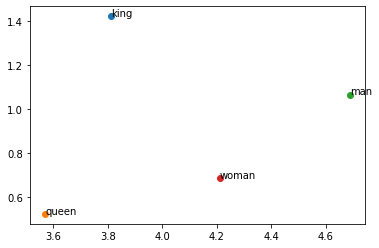

In [ ]:
# Visualize
plot_embeddings(
    words=["king", "queen", "man", "woman"], embeddings=glove,  
    pca_results=pca_results)

In [ ]:
# Bias in embeddings
glove.most_similar(positive=["woman", "doctor"], negative=["man"], topn=5)

[('nurse', 0.7735227346420288),
 ('physician', 0.7189429998397827),
 ('doctors', 0.6824328303337097),
 ('patient', 0.6750682592391968),
 ('dentist', 0.6726033687591553)]

# Set up

In [ ]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn

In [ ]:
SEED = 1234

In [ ]:
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU# Set seeds for reproducibility
set_seeds(seed=SEED)

In [ ]:
# Set seeds for reproducibility
set_seeds(seed=SEED)

In [ ]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

## Load data

We will download the [AG News dataset](http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html), which consists of 120K text samples from 4 unique classes (`Business`, `Sci/Tech`, `Sports`, `World`)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# Load data
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/news.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,title,category
0,The Spirit of St. Louis in outer space,Sci/Tech
1,Oil Rebounds \$1 as Heating Supplies Fall,Business
2,Orlovsky not bitter at BC,Sports
3,Report Says Air Force's Space Programs Improved,Sci/Tech
4,From the Grass Roots of Iowa Comes the Thinkin...,Sports


## Preprocessing

We're going to clean up our input data first by doing operations such as lower text, removing stop (filler) words, filters using regular expressions, etc.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [ ]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
print (STOPWORDS[:5])
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we']


In [ ]:
def preprocess(text, stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    text = pattern.sub('', text)

    # Remove words in paranthesis
    text = re.sub(r'\([^)]*\)', '', text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric chars
    text = re.sub(' +', ' ', text)  # remove multiple spaces
    text = text.strip()

    return text

In [ ]:
# Sample
text = "Great week for the NYSE!"
preprocess(text=text)

'great week nyse'

In [ ]:
# Apply to dataframe
preprocessed_df = df.copy()
preprocessed_df.title = preprocessed_df.title.apply(preprocess)
print (f"{df.title.values[0]}\n\n{preprocessed_df.title.values[0]}")

The Spirit of St. Louis in outer space

spirit st louis outer space


> If you have preprocessing steps like standardization, etc. that are calculated, you need to separate the training and test set first before applying those operations. This is because we cannot apply any knowledge gained from the test set accidentally (data leak) during preprocessing/training. However for global preprocessing steps like the function above where we aren't learning anything from the data itself, we can perform before splitting the data.

## Split data

In [ ]:
import collections
from sklearn.model_selection import train_test_split

In [ ]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [ ]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# Data
X = preprocessed_df["title"].values
y = preprocessed_df["category"].values

In [ ]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (84000,), y_train: (84000,)
X_val: (18000,), y_val: (18000,)
X_test: (18000,), y_test: (18000,)
Sample point: nba wrap neal pours 40 heat subdue wizards → Sports


## LabelEncoder

Next we'll define a `LabelEncoder` to encode our text labels into unique indices

In [ ]:
import itertools

In [ ]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
NUM_CLASSES = len(label_encoder)
label_encoder.class_to_index

{'Business': 0, 'Sci/Tech': 1, 'Sports': 2, 'World': 3}

In [ ]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: Sports
y_train[0]: 2


In [ ]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [21000 21000 21000 21000]
weights: {0: 4.761904761904762e-05, 1: 4.761904761904762e-05, 2: 4.761904761904762e-05, 3: 4.761904761904762e-05}


## Tokenizer

We'll define a `Tokenizer` to convert our text input data into token indices.

In [ ]:
import json
from collections import Counter
from more_itertools import take

In [ ]:
class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None, 
                 pad_token='<PAD>', oov_token='<UNK>',
                 token_to_index=None):
        self.char_level = char_level
        self.separator = '' if self.char_level else ' '
        if num_tokens: num_tokens -= 2 # pad + unk tokens
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)

    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(" ") for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(' ')
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(np.asarray(sequence))
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {
                "char_level": self.char_level,
                "oov_token": self.oov_token,
                "token_to_index": self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

> It's important that we only fit using our train data split because during inference, our model will not always know every token so it's important to replicate that scenario with our validation and test splits as well.

In [ ]:
# Tokenize
tokenizer = Tokenizer(char_level=False, num_tokens=5000)
tokenizer.fit_on_texts(texts=X_train)
VOCAB_SIZE = len(tokenizer)
print (tokenizer)

<Tokenizer(num_tokens=5000)>


In [ ]:
# Sample of tokens
print (take(5, tokenizer.token_to_index.items()))
print (f"least freq token's freq: {tokenizer.min_token_freq}") # use this to adjust num_tokens

[('<PAD>', 0), ('<UNK>', 1), ('39', 2), ('b', 3), ('gt', 4)]
least freq token's freq: 14


In [ ]:
# Convert texts to sequences of indices
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)
preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train[0]}")

Text to indices:
  (preprocessed) → nba wrap neal <UNK> 40 heat <UNK> wizards
  (tokenized) → [ 299  359 3869    1 1648  734    1 2021]


# Embedding layer

We can embed our inputs using PyTorch's [embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding).

In [ ]:
# Input
vocab_size = 10
x = torch.randint(high=vocab_size, size=(1,5))
print (x)
print (x.shape)

tensor([[2, 6, 5, 2, 6]])
torch.Size([1, 5])


In [ ]:
# Embedding layer
embeddings = nn.Embedding(embedding_dim=100, num_embeddings=vocab_size)
print (embeddings.weight.shape)

torch.Size([10, 100])


In [ ]:
# Embed the input
embeddings(x).shape

torch.Size([1, 5, 100])

Each token in the input is represented via embeddings (all out-of-vocabulary (OOV) tokens are given the embedding for `UNK` token.) In the model below, we'll see how to set these embeddings to be pretrained GloVe embeddings and how to choose whether to freeze (fixed embedding weights) those embeddings or not during training.

# Padding

Our inputs are all of varying length but we need each batch to be uniformly shaped. Therefore, we will use padding to make all the inputs in the batch the same length. Our padding index will be 0 (note that this is consistent with the `<PAD>` token defined in our `Tokenizer`).

> While embedding our input tokens will create a batch of shape (`N`, `max_seq_len`, `embed_dim`) we only need to provide a 2D matrix (`N`, `max_seq_len`) for using embeddings with PyTorch.

In [ ]:
def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max length in sequence."""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [ ]:
# 2D sequences
padded = pad_sequences(X_train[0:3])
print (padded.shape)
print (padded)

(3, 8)
[[2.990e+02 3.590e+02 3.869e+03 1.000e+00 1.648e+03 7.340e+02 1.000e+00
  2.021e+03]
 [4.977e+03 1.000e+00 8.070e+02 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00]
 [5.900e+01 1.213e+03 1.160e+02 4.042e+03 2.040e+02 4.190e+02 1.000e+00
  0.000e+00]]


# Dataset

We're going to create Datasets and DataLoaders to be able to efficiently create batches with our data splits.

In [ ]:
FILTER_SIZES = list(range(1, 4)) # uni, bi and tri grams

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        batch = np.array(batch, dtype=object)
        X = batch[:, 0]
        y = np.stack(batch[:, 1], axis=0)

        # Pad sequences
        X = pad_sequences(X)

        # Cast
        X = torch.LongTensor(X.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))

        return X, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self, batch_size=batch_size, collate_fn=self.collate_fn,
            shuffle=shuffle, drop_last=drop_last, pin_memory=True)

In [ ]:
# Create datasets
max_filter_size = max(FILTER_SIZES)
train_dataset = Dataset(X=X_train, y=y_train, max_filter_size=max_filter_size)
val_dataset = Dataset(X=X_val, y=y_val, max_filter_size=max_filter_size)
test_dataset = Dataset(X=X_test, y=y_test, max_filter_size=max_filter_size)
print ("Datasets:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  y: {train_dataset[0][1]}")

Datasets:
  Train dataset:<Dataset(N=84000)>
  Val dataset: <Dataset(N=18000)>
  Test dataset: <Dataset(N=18000)>
Sample point:
  X: [ 299  359 3869    1 1648  734    1 2021]
  y: 2


In [ ]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f"  y: {batch_y[0]}")

Sample batch:
  X: [64, 9]
  y: [64]
Sample point:
  X: tensor([ 299,  359, 3869,    1, 1648,  734,    1, 2021,    0], device="cpu")
  y: 2


# Model

We'll be using a convolutional neural network on top of our embedded tokens to extract meaningful spatial signal. This time, we'll be using many filter widths to act as n-gram feature extractors.

Let's visualize the model's forward pass.

1. We'll first tokenize our inputs (`batch_size`, `max_seq_len`).
2. Then we'll embed our tokenized inputs (`batch_size`, `max_seq_len`, `embedding_dim`).
3. We'll apply convolution via filters (`filter_size`, `vocab_size`, `num_filters`) followed by batch normalization. Our filters act as character level n-gram detecors. We have three different filter sizes (2, 3 and 4) and they will act as bi-gram, tri-gram and 4-gram feature extractors, respectivelyy. 
4. We'll apply 1D global max pooling which will extract the most relevant information from the feature maps for making the decision.
5. We feed the pool outputs to a fully-connected (FC) layer (with dropout).
6. We use one more FC layer with softmax to derive class probabilities. 

<div align="left">
<img src="https://madewithml.com/static/images/foundations/embeddings/model.png" width="1000">
</div>

In [ ]:
import math
import torch.nn.functional as F

In [ ]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
DROPOUT_P = 0.1

In [ ]:
class CNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters, 
                 filter_sizes, hidden_dim, dropout_p, num_classes, 
                 pretrained_embeddings=None, freeze_embeddings=False,
                 padding_idx=0):
        super(CNN, self).__init__()

        # Filter sizes
        self.filter_sizes = filter_sizes
        
        # Initialize embeddings
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx, _weight=pretrained_embeddings)
        
        # Freeze embeddings or not
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False
        
        # Conv weights
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim, 
                       out_channels=num_filters, 
                       kernel_size=f) for f in filter_sizes])
     
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first=False):
        
        # Embed
        x_in, = inputs
        x_in = self.embeddings(x_in)

        # Rearrange input so num_channels is in dim 1 (N, C, L)
        if not channel_first:
            x_in = x_in.transpose(1, 2)
            
        # Conv outputs
        z = []
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):
            # `SAME` padding
            padding_left = int((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))

            # Conv + pool
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))
            _z = F.max_pool1d(_z, _z.size(2)).squeeze(2)
            z.append(_z)
        
        # Concat conv outputs
        z = torch.cat(z, 1)

        # FC layers
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.fc2(z)
        return z

# GloVe embeddings

We're going create some utility functions to be able to load the pretrained GloVe embeddings into our Embeddings layer.

In [ ]:
def load_glove_embeddings(embeddings_file):
    """Load embeddings from a file."""
    embeddings = {}
    with open(embeddings_file, "r") as fp:
        for index, line in enumerate(fp):
            values = line.split()
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings[word] = embedding
    return embeddings

In [ ]:
def make_embeddings_matrix(embeddings, word_index, embedding_dim):
    """Create embeddings matrix to use in Embedding layer."""
    embedding_matrix = np.zeros((len(word_index), embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
# Create embeddings
embeddings_file = 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)
glove_embeddings = load_glove_embeddings(embeddings_file=embeddings_file)
embedding_matrix = make_embeddings_matrix(
    embeddings=glove_embeddings, word_index=tokenizer.token_to_index, 
    embedding_dim=EMBEDDING_DIM)
print (f"<Embeddings(words={embedding_matrix.shape[0]}, dim={embedding_matrix.shape[1]})>")

<Embeddings(words=5000, dim=100)>


# Experiments

We have first have to decice whether to use pretrained embeddings randomly initialized ones. Then, we can choose to freeze our embeddings or continue to train them using the supervised data (this could lead to overfitting). Here are the three experiments we're going to conduct: 
* randomly initialized embeddings (fine-tuned)
* GloVe embeddings (frozen)
* GloVe embeddings (fine-tuned)

In [ ]:
import json
from sklearn.metrics import precision_recall_fscore_support
from torch.optim import Adam

In [ ]:
NUM_FILTERS = 50
LEARNING_RATE = 1e-3
PATIENCE = 5
NUM_EPOCHS = 10

In [ ]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                z = self.model(inputs)

                # Store outputs
                y_prob = F.softmax(z).cpu().numpy()
                y_probs.extend(y_prob)

        return np.vstack(y_probs)
    
    def train(self, num_epochs, patience, train_dataloader, val_dataloader):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

In [ ]:
def get_performance(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

### Randomly initialized embeddings

In [ ]:
PRETRAINED_EMBEDDINGS = None
FREEZE_EMBEDDINGS = False

In [ ]:
# Initialize model
model = CNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE, 
    num_filters=NUM_FILTERS, filter_sizes=FILTER_SIZES,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES,
    pretrained_embeddings=PRETRAINED_EMBEDDINGS, freeze_embeddings=FREEZE_EMBEDDINGS)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [ ]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
# Define optimizer & scheduler
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)

In [ ]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn, 
    optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)

Epoch: 1 | train_loss: 0.77038, val_loss: 0.59683, lr: 1.00E-03, _patience: 3
Epoch: 2 | train_loss: 0.49571, val_loss: 0.54363, lr: 1.00E-03, _patience: 3
Epoch: 3 | train_loss: 0.40796, val_loss: 0.54551, lr: 1.00E-03, _patience: 2
Epoch: 4 | train_loss: 0.34797, val_loss: 0.57950, lr: 1.00E-03, _patience: 1
Stopping early!


In [ ]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

In [ ]:
# Determine performance
performance = get_performance(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

{
  "precision": 0.8070310520771562,
  "recall": 0.7999444444444445,
  "f1": 0.8012357147662316,
  "num_samples": 18000.0
}


### GloVe embeddings (frozen)

In [ ]:
PRETRAINED_EMBEDDINGS = embedding_matrix
FREEZE_EMBEDDINGS = True

In [ ]:
# Initialize model
model = CNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE, 
    num_filters=NUM_FILTERS, filter_sizes=FILTER_SIZES,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES,
    pretrained_embeddings=PRETRAINED_EMBEDDINGS, freeze_embeddings=FREEZE_EMBEDDINGS)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [ ]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
# Define optimizer & scheduler
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)

In [ ]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn, 
    optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)

Epoch: 1 | train_loss: 0.51510, val_loss: 0.47643, lr: 1.00E-03, _patience: 3
Epoch: 2 | train_loss: 0.44220, val_loss: 0.46124, lr: 1.00E-03, _patience: 3
Epoch: 3 | train_loss: 0.41204, val_loss: 0.46231, lr: 1.00E-03, _patience: 2
Epoch: 4 | train_loss: 0.38733, val_loss: 0.46606, lr: 1.00E-03, _patience: 1
Stopping early!


In [ ]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

In [ ]:
# Determine performance
performance = get_performance(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

{
  "precision": 0.8304874226557859,
  "recall": 0.8281111111111111,
  "f1": 0.828556487688813,
  "num_samples": 18000.0
}


### Fine-tuned GloVe embeddings (unfrozen)

In [ ]:
PRETRAINED_EMBEDDINGS = embedding_matrix
FREEZE_EMBEDDINGS = False

In [ ]:
# Initialize model
model = CNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE, 
    num_filters=NUM_FILTERS, filter_sizes=FILTER_SIZES,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES,
    pretrained_embeddings=PRETRAINED_EMBEDDINGS, freeze_embeddings=FREEZE_EMBEDDINGS)
model = model.to(device) # set device
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [ ]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
# Define optimizer & scheduler
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3)

In [ ]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn, 
    optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    NUM_EPOCHS, PATIENCE, train_dataloader, val_dataloader)

Epoch: 1 | train_loss: 0.48908, val_loss: 0.44320, lr: 1.00E-03, _patience: 3
Epoch: 2 | train_loss: 0.38986, val_loss: 0.43616, lr: 1.00E-03, _patience: 3
Epoch: 3 | train_loss: 0.34403, val_loss: 0.45240, lr: 1.00E-03, _patience: 2
Epoch: 4 | train_loss: 0.30224, val_loss: 0.49063, lr: 1.00E-03, _patience: 1
Stopping early!


In [ ]:
# Get predictions
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.argmax(y_prob, axis=1)

In [ ]:
# Determine performance
performance = get_performance(
    y_true=y_test, y_pred=y_pred, classes=label_encoder.classes)
print (json.dumps(performance["overall"], indent=2))

{
  "precision": 0.8297157849772082,
  "recall": 0.8263333333333334,
  "f1": 0.8266579939871359,
  "num_samples": 18000.0
}


In [ ]:
# Save artifacts
from pathlib import Path
dir = Path("cnn")
dir.mkdir(parents=True, exist_ok=True)
label_encoder.save(fp=Path(dir, "label_encoder.json"))
tokenizer.save(fp=Path(dir, 'tokenizer.json'))
torch.save(best_model.state_dict(), Path(dir, "model.pt"))
with open(Path(dir, 'performance.json'), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

# Inference

In [ ]:
def get_probability_distribution(y_prob, classes):
    """Create a dict of class probabilities from an array."""
    results = {}
    for i, class_ in enumerate(classes):
        results[class_] = np.float64(y_prob[i])
    sorted_results = {k: v for k, v in sorted(
        results.items(), key=lambda item: item[1], reverse=True)}
    return sorted_results

In [ ]:
# Load artifacts
device = torch.device("cpu")
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
tokenizer = Tokenizer.load(fp=Path(dir, 'tokenizer.json'))
model = CNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE, 
    num_filters=NUM_FILTERS, filter_sizes=FILTER_SIZES,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES,
    pretrained_embeddings=PRETRAINED_EMBEDDINGS, freeze_embeddings=FREEZE_EMBEDDINGS)
model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
model.to(device)

CNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [ ]:
# Initialize trainer
trainer = Trainer(model=model, device=device)

In [ ]:
# Dataloader
text = "The final tennis tournament starts next week."
X = tokenizer.texts_to_sequences([preprocess(text)])
print (tokenizer.sequences_to_texts(X))
y_filler = label_encoder.encode([label_encoder.classes[0]]*len(X))
dataset = Dataset(X=X, y=y_filler, max_filter_size=max_filter_size)
dataloader = dataset.create_dataloader(batch_size=batch_size)

['final tennis tournament starts next week']


In [ ]:
# Inference
y_prob = trainer.predict_step(dataloader)
y_pred = np.argmax(y_prob, axis=1)
label_encoder.decode(y_pred)

['Sports']

In [ ]:
# Class distributions
prob_dist = get_probability_distribution(y_prob=y_prob[0], classes=label_encoder.classes)
print (json.dumps(prob_dist, indent=2))

{
  "Sports": 0.9999998807907104,
  "World": 6.336378532978415e-08,
  "Sci/Tech": 2.107449992294619e-09,
  "Business": 3.706519813295728e-10
}


# Interpretability

We went through all the trouble of padding our inputs before convolution to result is outputs of the same shape as our inputs so we can try to get some interpretability. Since every token is mapped to a convolutional output on which we apply max pooling, we can see which token's output was most influential towards the prediction. We first need to get the conv outputs from our model:

In [ ]:
import collections
import seaborn as sns

In [ ]:
class InterpretableCNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters, 
                 filter_sizes, hidden_dim, dropout_p, num_classes, 
                 pretrained_embeddings=None, freeze_embeddings=False,
                 padding_idx=0):
        super(InterpretableCNN, self).__init__()

        # Filter sizes
        self.filter_sizes = filter_sizes
        
        # Initialize embeddings
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx, _weight=pretrained_embeddings)
        
        # Freeze embeddings or not
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False
        
        # Conv weights
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim, 
                       out_channels=num_filters, 
                       kernel_size=f) for f in filter_sizes])
     
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first=False):
        
        # Embed
        x_in, = inputs
        x_in = self.embeddings(x_in)

        # Rearrange input so num_channels is in dim 1 (N, C, L)
        if not channel_first:
            x_in = x_in.transpose(1, 2)
            
        # Conv outputs
        z = []
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):
            # `SAME` padding
            padding_left = int((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))

            # Conv + pool
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))
            z.append(_z.cpu().numpy())

        return z

In [ ]:
PRETRAINED_EMBEDDINGS = embedding_matrix
FREEZE_EMBEDDINGS = False

In [ ]:
# Initialize model
interpretable_model = InterpretableCNN(
    embedding_dim=EMBEDDING_DIM, vocab_size=VOCAB_SIZE, 
    num_filters=NUM_FILTERS, filter_sizes=FILTER_SIZES,
    hidden_dim=HIDDEN_DIM, dropout_p=DROPOUT_P, num_classes=NUM_CLASSES,
    pretrained_embeddings=PRETRAINED_EMBEDDINGS, freeze_embeddings=FREEZE_EMBEDDINGS)
interpretable_model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
interpretable_model.to(device)

InterpretableCNN(
  (embeddings): Embedding(5000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(1,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)

In [ ]:
# Initialize trainer
interpretable_trainer = Trainer(model=interpretable_model, device=device)

In [ ]:
# Get conv outputs
conv_outputs = interpretable_trainer.predict_step(dataloader)
print (conv_outputs.shape) # (len(filter_sizes), num_filters, max_seq_len)

(3, 50, 6)


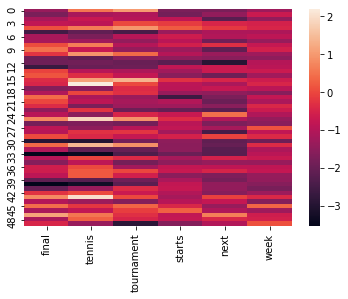

In [ ]:
# Visualize a bi-gram filter's outputs
tokens = tokenizer.sequences_to_texts(X)[0].split(' ')
sns.heatmap(conv_outputs[1], xticklabels=tokens)

1D global max-pooling would extract the highest value from each of our `num_filters` for each `filter_size`. We could also follow this same approach to figure out which n-gram is most relevant but notice in the heatmap above that many filters don't have much variance. To mitigate this, this [paper](https://www.aclweb.org/anthology/W18-5408/) uses threshold values to determine which filters to use for interpretability. But to keep things simple, let's extract which tokens' filter outputs were extracted via max-pooling the most frequently. 

In [ ]:
sample_index = 0
print (f"Origin text:\n{text}")
print (f"\nPreprocessed text:\n{tokenizer.sequences_to_texts(X)[0]}")
print ("\nMost important n-grams:")
# Process conv outputs for each unique filter size
for i, filter_size in enumerate(FILTER_SIZES):

    # Identify most important n-gram (excluding last token)
    popular_indices = collections.Counter([np.argmax(conv_output) \
            for conv_output in conv_outputs[i]])
    
    # Get corresponding text
    start = popular_indices.most_common(1)[-1][0]
    n_gram = " ".join([token for token in tokens[start:start+filter_size]])
    print (f"[{filter_size}-gram]: {n_gram}")

Origin text:
The final tennis tournament starts next week.

Preprocessed text:
final tennis tournament starts next week

Most important n-grams:
[1-gram]: tennis
[2-gram]: tennis tournament
[3-gram]: final tennis tournament
